In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from cellpose import plot
import os
from scipy.signal import find_peaks
from skimage.measure import label, regionprops, regionprops_table
from skimage.color import label2rgb
import pandas as pd
import glob
import pathlib
import seaborn as sns
from pip._internal.cli.progress_bars import get_download_progress_renderer
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# warnings.filterwarnings("ignore")

import sys
sys.path.append('../vasco_scripts')  # add the relative path to the folder
from defects import *  # import the module from the folder

def find_centers(masks):
    '''find centers in segmented image b/w or labels'''
    regions = regionprops(masks)
    x_cent = []
    y_cent = []
    label_num = []
    for i,props in enumerate(regions):
        yi, xi = props.centroid
        x_cent.append(xi)
        y_cent.append(yi)
        label_num.append(props.label)
        # plt.text(xi, yi, str(i))
    return x_cent, y_cent, label_num

def brightness(image, mask, labels):
    '''measure raw image intenslity for each mask label'''
    intensity = []
    for l in labels:
        intensity.append(image[mask==l].mean())
        progressBar(l,len(labels))
        
    return intensity 

def center_pairs(Xlong, Xshort):
    '''find indexes of Xshort in Xlong'''
    from scipy import spatial
    tree = spatial.KDTree(Xlong)
    _, minid = tree.query(Xshort)   
    return minid

import sys,time,random
def progressBar(count_value, total, suffix=''):
    bar_length = 100
    filled_up_Length = int(round(bar_length* count_value / float(total)))
    percentage = round(100.0 * count_value/float(total),1)
    bar = '=' * filled_up_Length + '-' * (bar_length - filled_up_Length)
    sys.stdout.write('[%s] %s%s ...%s\r' %(bar, percentage, '%', suffix))
    sys.stdout.flush()

folder = r"C:\Users\victo\Downloads\SB_lab\HBEC\s2(120-919)"

c:\Users\victo\miniconda3\envs\cellpose\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [2]:
data_path = r"C:\Users\victo\Downloads\SB_lab\HBEC\s2(120-919)\Tracking\spots_100_500.csv"
track_df = pd.read_csv(data_path, skiprows=[1,2,3]).reset_index()
track_df["DIVIDING"] = 0

In [3]:
folder = r"C:\Users\victo\Downloads\SB_lab\HBEC\s2(120-919)"
raw_list = sorted(glob.glob(folder + "/*.tif"))
mask_list = []
for raw in raw_list:
    mask_path = os.path.join(
        str(pathlib.Path(raw).parents[0]), 
        "Mask", 
        raw.split(os.sep)[-1].split(".")[0]+"_cp_masks.png"
        )    
    mask_list.append(mask_path)
div_mask_list = []
for raw in raw_list:
    mask_path = os.path.join(
        str(pathlib.Path(raw).parents[0]), 
        "DivMask", 
        raw.split(os.sep)[-1].split(".")[0]+"_div_mask.png"
        )    
    div_mask_list.append(mask_path)    

C:\Users\victo\AppData\Local\Temp\ipykernel_8988\3394765655.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['DIVIDING'][df['POSITION_X'][intensity[idx]>tresh].index] = 1


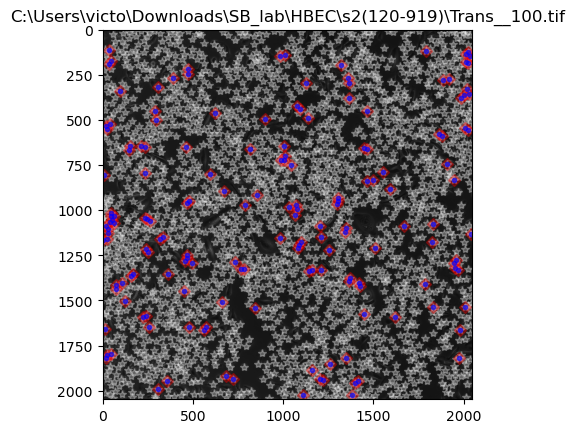

In [4]:
# !!! takes about 90 min
tresh = 60

for i,frame in enumerate(track_df['FRAME'].unique()):
    img = cv2.imread(raw_list[i+99])
    mask = cv2.imread(mask_list[i+99],flags=cv2.IMREAD_ANYDEPTH)
    div_mask = cv2.imread(div_mask_list[i+99],flags=cv2.IMREAD_ANYDEPTH)
    x_cent, y_cent, label_num = find_centers(mask)
    intensity = brightness(div_mask, mask, label_num)
    x_cent, y_cent, intensity = np.array(x_cent), np.array(y_cent), np.array(intensity)

    df = track_df[track_df["FRAME"]==frame]
    # Register btw points (x,y) of two arrays
    # xy_seg[idx[:n]] == xy_track[:n]
    xy_seg = np.array([x_cent, y_cent]).T
    xy_track = np.array([df['POSITION_X'].values, df['POSITION_Y'].values]).T
    idx = center_pairs(
        xy_seg, #Long Array
        xy_track #Short Array
        ) 
    
    track_df['DIVIDING'][df['POSITION_X'][intensity[idx]>tresh].index] = 1

    # div_idx = track_df[np.logical_and.reduce((
    #     track_df["FRAME"]==frame,
    #     track_df["DIVIDING"]==1,))
    #     ].index
    
    # plt.imshow(img)
    # # plt.imshow(label2rgb(mask, bg_label=0), alpha=0.2)
    # for x,y in zip(df['POSITION_X'], df['POSITION_Y']):
    #     plt.plot(x,y,"*", color="white", alpha=.3)  

    # for x,y in zip(df['POSITION_X'][intensity[idx]>tresh], 
    #                 df['POSITION_Y'][intensity[idx]>tresh]):
    #     plt.plot(x,y,"D", color="red", alpha=.3)  

    # for x,y in zip(track_df['POSITION_X'][div_idx], 
    #                 track_df['POSITION_Y'][div_idx]):
    #     plt.plot(x,y,".", color="blue", alpha=.6)  

    # plt.title(raw_list[i+99])
    
    # break
    progressBar(i,len(track_df['FRAME'].unique()))
    
track_df[['index', 'ID', 'TRACK_ID',
       'POSITION_X', 'POSITION_Y', 'POSITION_Z', 'POSITION_T', 'FRAME',
       'RADIUS', 'ELLIPSE_X0', 'ELLIPSE_Y0', 'ELLIPSE_MAJOR', 'ELLIPSE_MINOR', 'ELLIPSE_THETA',
       'ELLIPSE_ASPECTRATIO', 'AREA', 'PERIMETER', 'CIRCULARITY', 'SOLIDITY',
       'SHAPE_INDEX', 'DIVIDING']].to_csv(r"C:\Users\victo\Downloads\SB_lab\HBEC\s2(120-919)\Tracking\spots_100_500_wdivs.csv")    

In [17]:
track_df1 = pd.read_csv(r"C:\Users\victo\Downloads\SB_lab\HBEC\s2(120-919)\Tracking\spots_100_500_wdivs.csv").dropna()
track_df1["T0"] = 0

`track_df1["T0"]` indicates first appereance of deviding cell

In [15]:
tracks_all = track_df1["TRACK_ID"][track_df1['DIVIDING']==1].unique()
for i,tid in enumerate(tracks_all):
    track_df1["T0"][track_df1[np.logical_and.reduce((
        track_df1["TRACK_ID"]==tid,
        track_df1["DIVIDING"]==1,
        ))].index[0]] = 1
    progressBar(i,len(tracks_all))

C:\Users\victo\AppData\Local\Temp\ipykernel_14800\2513734264.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df1["T0"][track_df1[np.logical_and.reduce((


In [16]:
track_df1.to_csv(r"C:\Users\victo\Downloads\SB_lab\HBEC\s2(120-919)\Tracking\spots_100_500_wdivs.csv") 

In [18]:
track_df1 = pd.read_csv(r"C:\Users\victo\Downloads\SB_lab\HBEC\s2(120-919)\Tracking\spots_100_500_wdivs.csv")

## Save images with dividing events

In [20]:
%matplotlib qt
tracks_all = track_df1["TRACK_ID"][track_df1['DIVIDING']==1].unique()
colors = plt.cm.tab10(np.linspace(0, 1, num=int(tracks_all.max())))
rng = np.random.default_rng()
colors = rng.permuted(colors, axis=0)

frames = track_df1["POSITION_T"][track_df1['DIVIDING']==1].unique()

for frame in frames[51:]:
    progressBar(frame,len(frames))
    im_path = os.path.join(
            folder,
            "Trans__"+str(int(frame)+100)+".tif")   
    
    div_idx = track_df1["DIVIDING"][np.logical_and.reduce((
            track_df1["POSITION_T"]==frame,
            track_df1["DIVIDING"]==1,
            # track_df1["T0"]==1,
            ))].index
    x_div = track_df1["POSITION_X"][div_idx]
    y_div = track_df1["POSITION_Y"][div_idx]
    id = track_df1["TRACK_ID"][div_idx].values.astype(int)
    t0 = track_df1["T0"][div_idx].values.astype(int)


    img = cv2.imread(im_path)
    d = 20
    for xi, yi, iid, it0 in zip(x_div, y_div, id, t0):
        if it0:
            cv2.rectangle(img, 
                (int(xi-d),int(yi-d)), (int(xi+d),int(yi+d)), 
                (100/1.2,165/1.2,0), 2)
        cv2.circle(img, (int(xi),int(yi)), radius=5, color=tuple(255*colors[iid, :3]), thickness=2)
        cv2.putText(img, str(iid), (int(xi),int(yi)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, tuple(255*colors[iid, :3]), 1)
    
    plt.imshow(img/img.max()) 
    break  

    div_path = os.path.join(
        str(pathlib.Path(im_path).parents[0]), 
        "Div1", 
        im_path.split(os.sep)[-1].split(".")[0]+"_div.png"
        )
    os.makedirs(os.path.dirname(div_path), exist_ok=True)
    cv2.imwrite(div_path,img)

In [43]:
colors.shape, iid

((63132, 4), 63132)